In [1]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

from cleaning import convert
from cleaning import splitter
from cleaning import text_preprocessing

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from typing import List


In [2]:
size = 500
filename = "imdb_df_500.csv"
root = f"C:/Users/Bijan-PC/Documents/Coding/UNIL/Data Analysis/ADA_Project/ADA_Final/dat_cleaned/{size}"      #base location for where all data files are
df = convert(root,filename)            #Definining dataframe where all training and validation data will be pulled from
df["id"] = df.index                            #creating id column
number_of_labels = len(df["label"].value_counts())          #number of labels (will be used when training)

In [3]:
number_of_labels

2

In [3]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_embeddings(texts: List[str], batch_size: int):
    all_embeddings = []
    print(f"Total number of records: {len(texts)}")
    print(f"Num batches: {(len(texts) // batch_size) + 1}")

    # Extract embeddings for the texts in batches
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[start_index:start_index + batch_size]

        # Generate tokens and move input tensors to GPU
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract the embeddings. no_grad because the gradient does not need to be computed
        # since this is not a learning task
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the last hidden stated and pool them into a mean vector calculated across the sequence length dimension
        # This will reduce the output vector from [batch_size, sequence_length, hidden_layer_size]
        # to [batch_size, hidden_layer_size] thereby generating the embeddings for all the sequences in the batch
        last_hidden_states = outputs.last_hidden_state
        embeddings = torch.mean(last_hidden_states, dim=1).cpu().tolist()

        # Append to the embeddings list
        all_embeddings.extend(embeddings)

    return all_embeddings

c:\Users\Bijan-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# Split into train and test
X = df.text.values
y = df.label.values

X_test, y_test, X_train, y_train, X_val, y_val = splitter(X,y)

In [5]:
X_test

array(['i have sacrificed so much for this man and when i think about these sacrifices i have made i feel selfish',
       'i loved the cozy color but all the dark items and lack of pop left me feeling dull instead of cozy',
       'i am actually finding myself sympathetic to how trapped lana is feeling even though rationally i dont agree that i should feel sympathetic just because kk was really on tonight especially in those last three scenes',
       'i feel a tender kiss on my forehead',
       'i felt slighted makes me feel petty and certainly isn t a good enough reason on its own to run',
       'i was impressed beautifeel shoes i was impressed beautifeel shoes august rd',
       'ive been really enjoying the sense of connectivity i feel when reading a particularly amazing blog a piece of literary brilliance or bravery where the writer has made you feel feelings that wake you up and make you strong with anger or pride or the need to incite change',
       'i don t feel saxually ab

In [6]:
X_train = pd.DataFrame(X_train, columns=['text'])
X_val = pd.DataFrame(X_val, columns=['text'])
X_test = pd.DataFrame(X_test, columns=['text'])

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_val = pd.Series(y_val)

In [7]:
for dataset in [X_test, X_train, X_val]:
    dataset["text_cleaned"] = dataset["text"].apply(lambda x: text_preprocessing(x))
    print(f'Cleaned {len(dataset["text_cleaned"])} records in dataset')

Cleaned 300 records in dataset
Cleaned 2400 records in dataset
Cleaned 300 records in dataset


In [8]:
from collections import Counter

# Get class counts
print(Counter(y_train))

Counter({4: 411, 0: 407, 2: 407, 1: 402, 5: 387, 3: 386})


In [9]:

# Get embeddings for the training and test set
train_embeddings = get_embeddings(texts=X_train["text_cleaned"].tolist(), batch_size=256)
train_embeddings_df = pd.DataFrame(train_embeddings)

test_embeddings = get_embeddings(texts=X_test["text_cleaned"].tolist(), batch_size=256)
test_embeddings_df = pd.DataFrame(test_embeddings)

val_embeddings = get_embeddings(texts=X_val["text_cleaned"].tolist(), batch_size=256)
val_embeddings_df = pd.DataFrame(val_embeddings)

Total number of records: 2400
Num batches: 10


100%|██████████| 10/10 [00:00<00:00, 13.93it/s]


Total number of records: 300
Num batches: 2


100%|██████████| 2/2 [00:00<00:00, 44.22it/s]


Total number of records: 300
Num batches: 2


100%|██████████| 2/2 [00:00<00:00, 42.30it/s]


In [10]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    boost_device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not the cpu will be used
else:
    print('No GPU available, using the CPU instead.')
    boost_device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080 SUPER


In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def train_model(data: pd.DataFrame, labels: pd.Series):

    # Initialize the XGBoost Classifier
    xgb_clf = xgb.XGBClassifier(objective="multi:softmax",
                                num_class = number_of_labels,
                                device=boost_device,
                                random_state=3137)

    # Define hyperparameters and values to tune
    param_grid = {
        'max_depth': [5, 6, 7, 8],
        'eta': np.arange(0.05, 0.3, 0.05)
    }

    print(f"Number of rows in training data: {len(data)}")

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring="roc_auc_ovo",
                               cv=5, verbose=3)
    grid_search.fit(data, labels)

    # Get the best hyperparameters
    best_max_depth = grid_search.best_params_['max_depth']
    best_eta = grid_search.best_params_['eta']

    final_xgb_clf = xgb.XGBClassifier(objective="multi:softmax",
                                      max_depth=best_max_depth,
                                      eta=best_eta,
                                      device=boost_device,
                                      random_state=3137)
    final_xgb_clf.fit(data, labels)

    return final_xgb_clf

In [12]:

def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(number_of_labels, number_of_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    #plt.show()

In [ ]:


# Train model
xgb_model = train_model(data=train_embeddings_df, labels=y_train)

# Predict from model on validation data
y_pred_val = xgb_model.predict(val_embeddings_df)
#y_pred_labels = [label_dict[x] for x in y_pred]
y_pred_val = pd.Series(y_pred_val)


# Predict from model on test data
y_pred_test = xgb_model.predict(test_embeddings_df)
#y_pred_labels = [label_dict[x] for x in y_pred]
y_pred_test = pd.Series(y_pred_test)

# Evaluate model (validation data)
print(f"Classification report:\n{classification_report(y_val, y_pred_val)}")
print(plot_confusion_matrix(y_val, y_pred_val))

# Evaluate model (test data)
print(f"Classification report:\n{classification_report(y_val, y_pred_test)}")
print(plot_confusion_matrix(y_test, y_pred_test))

c:\Users\Bijan-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Cleaned 300 records in dataset
Cleaned 2400 records in dataset
Cleaned 300 records in dataset
Total number of records: 2400
Num batches: 10


100%|██████████| 10/10 [00:00<00:00, 30.76it/s]


Total number of records: 300
Num batches: 2


100%|██████████| 2/2 [00:00<00:00, 43.88it/s]


Total number of records: 300
Num batches: 2


100%|██████████| 2/2 [00:00<00:00, 43.77it/s]


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080 SUPER
Number of rows in training data: 2400
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Bijan-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END .............eta=0.05, max_depth=5;, score=0.793 total time=   1.5s
[CV 2/5] END .............eta=0.05, max_depth=5;, score=0.799 total time=   1.6s
[CV 3/5] END .............eta=0.05, max_depth=5;, score=0.826 total time=   1.5s
[CV 4/5] END .............eta=0.05, max_depth=5;, score=0.824 total time=   1.6s
[CV 5/5] END .............eta=0.05, max_depth=5;, score=0.787 total time=   1.5s
[CV 1/5] END .............eta=0.05, max_depth=6;, score=0.794 total time=   2.5s
[CV 2/5] END .............eta=0.05, max_depth=6;, score=0.798 total time=   2.5s
[CV 3/5] END .............eta=0.05, max_depth=6;, score=0.820 total time=   2.3s
[CV 4/5] END .............eta=0.05, max_depth=6;, score=0.830 total time=   2.4s
[CV 5/5] END .............eta=0.05, max_depth=6;, score=0.792 total time=   2.4s
[CV 1/5] END .............eta=0.05, max_depth=7;, score=0.786 total time=   3.3s
[CV 2/5] END .............eta=0.05, max_depth=7;, score=0.787 total time=   3.3s
[CV 3/5] END .............et

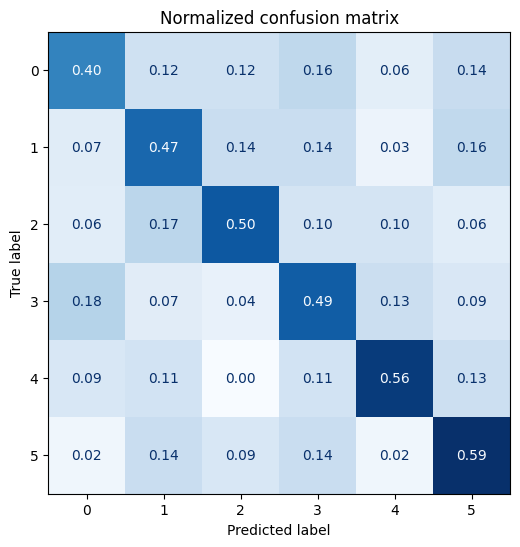

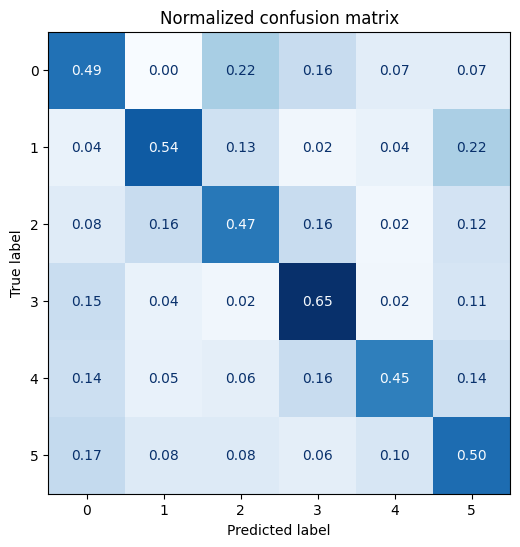

In [13]:
from BERT_XGBOOST import bert_xgboost

bert_xgboost('twit_df_500.csv', 500, test=True)